## Get packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor  # Import XGBoost models
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
import keras.backend as K
from keras.regularizers import l2, l1, l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss, accuracy_score

import logging
from tqdm import tqdm

## Import and pre-process data

In [3]:
# Load the dataset
data = pd.read_csv('data/data_clean.csv')
data.head()

,customer_number,stage_grouped,max_closed_date,cloud_revenue,total_opp_amount,employees,country,industry,ee_count,contacts_count,...,part_request_events,part_request_days_used,share_events,share_days_used,tasks_events,tasks_days_used,version_control_events,version_control_days_used,web_review_events,web_review_days_used
0,11325,lost,8/15/24,15487.00,10497.00,850,UNITED STATES,Industrial/Instrumentation,4,70,...,176,48,63,6,82,11,10022,151,8051,133
1,11329,won,7/31/24,999.00,999.00,2683,UNITED STATES,Electronic Component and Semiconductor,17,301,...,8,7,48,13,29,7,8343,149,6650,131
2,11336,won,7/25/24,72231.75,72231.75,1893,UNITED STATES,Industrial/Instrumentation,55,241,...,0,0,1,1,0,0,502,78,147,17
3,11816,won,3/31/24,45747.30,154342.39,5000,UNITED STATES,Industrial/Instrumentation,23,85,...,27,14,4,2,20,10,2633,65,1052,59
4,11872,lost,11/7/23,15000.00,15000.00,129,UNITED STATES,Aerospace,21,115,...,1,1,0,0,0,0,64,6,2,2


In [4]:
len(data)

883

In [5]:
data.columns

Index(['customer_number', 'stage_grouped', 'max_closed_date', 'cloud_revenue',
       'total_opp_amount', 'employees', 'country', 'industry', 'ee_count',
       'contacts_count', 'non_ee_count', 'emb_world_attendees', 'email_clicks',
       'a365_new_wb_visits', 'a365_rest_wb_visits', 'total_webinars_attended',
       'total_webinar_attendees', 'assembly_app_events',
       'assembly_app_days_used', 'comms_events', 'comms_days_used',
       'libs_events', 'libs_days_used', 'manufacturing_events',
       'manufacturing_days_used', 'mcad_events', 'mcad_days_used',
       'multi_cad_events', 'multi_cad_days_used', 'part_request_events',
       'part_request_days_used', 'share_events', 'share_days_used',
       'tasks_events', 'tasks_days_used', 'version_control_events',
       'version_control_days_used', 'web_review_events',
       'web_review_days_used'],
      dtype='object')

In [6]:
# See distinct industries
data['industry'].value_counts()

industry
Industrial/Instrumentation                192
Service Bureau / Engineering Services     159
Aerospace                                  76
Medical Device                             76
Consumer Electronics                       66
Communications                             61
Electronic Component and Semiconductor     46
Automotive                                 38
Military/Defense                           35
Component OEM                              17
Maritime                                   17
Academic                                   10
Electronics                                10
Engineering                                 8
Manufacturing                               7
Retail                                      7
Consulting                                  5
Machinery                                   5
Other                                       4
Industrial Manufacturing and Services       2
Hospitals and Healthcare                    1
Construction             

In [7]:
# Combine similar industries
industry_mapping = {
    'Aerospace & Defense': 'Aerospace',
    'Medical Device': 'Medical Devices'
}
data['industry'] = data['industry'].replace(industry_mapping)

In [8]:
# Use pd.get_dummies to one-hot encode the 'industry' column and any other categorical columns
data = pd.get_dummies(data, columns=['industry'], drop_first=True)
data.columns

Index(['customer_number', 'stage_grouped', 'max_closed_date', 'cloud_revenue',
       'total_opp_amount', 'employees', 'country', 'ee_count',
       'contacts_count', 'non_ee_count', 'emb_world_attendees', 'email_clicks',
       'a365_new_wb_visits', 'a365_rest_wb_visits', 'total_webinars_attended',
       'total_webinar_attendees', 'assembly_app_events',
       'assembly_app_days_used', 'comms_events', 'comms_days_used',
       'libs_events', 'libs_days_used', 'manufacturing_events',
       'manufacturing_days_used', 'mcad_events', 'mcad_days_used',
       'multi_cad_events', 'multi_cad_days_used', 'part_request_events',
       'part_request_days_used', 'share_events', 'share_days_used',
       'tasks_events', 'tasks_days_used', 'version_control_events',
       'version_control_days_used', 'web_review_events',
       'web_review_days_used', 'industry_Aerospace', 'industry_Automotive',
       'industry_Chemicals', 'industry_Communications',
       'industry_Component OEM', 'industry_Co

In [9]:
# Encode the 'stage_grouped' column using LabelEncoder if it is of object type
data['stage_grouped'] = data['stage_grouped'].apply(lambda x: 1 if x == 'won' else 0)
data.head()

,customer_number,stage_grouped,max_closed_date,cloud_revenue,total_opp_amount,employees,country,ee_count,contacts_count,non_ee_count,...,industry_Manufacturing,industry_Maritime,industry_Medical Devices,industry_Military/Defense,industry_Non-Traditional Sectors,industry_Other,industry_Retail,industry_Service Bureau / Engineering Services,industry_Technology,industry_Telecommunications
0,11325,0,8/15/24,15487.00,10497.00,850,UNITED STATES,4,70,31,...,False,False,False,False,False,False,False,False,False,False
1,11329,1,7/31/24,999.00,999.00,2683,UNITED STATES,17,301,85,...,False,False,False,False,False,False,False,False,False,False
2,11336,1,7/25/24,72231.75,72231.75,1893,UNITED STATES,55,241,85,...,False,False,False,False,False,False,False,False,False,False
3,11816,1,3/31/24,45747.30,154342.39,5000,UNITED STATES,23,85,26,...,False,False,False,False,False,False,False,False,False,False
4,11872,0,11/7/23,15000.00,15000.00,129,UNITED STATES,21,115,50,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# See count of missing values in each column
data.isnull().sum()[data.isnull().sum() > 0]


Series([], dtype: int64)

In [11]:
# Handle missing values
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

## Analyze features

In [12]:
# Columns to drop
columns_to_drop = ['customer_number','stage_grouped','max_closed_date','cloud_revenue','total_opp_amount','country']

# Create feature sets
X = data.drop(columns=columns_to_drop)

# List out columns of X as features
features = X.columns

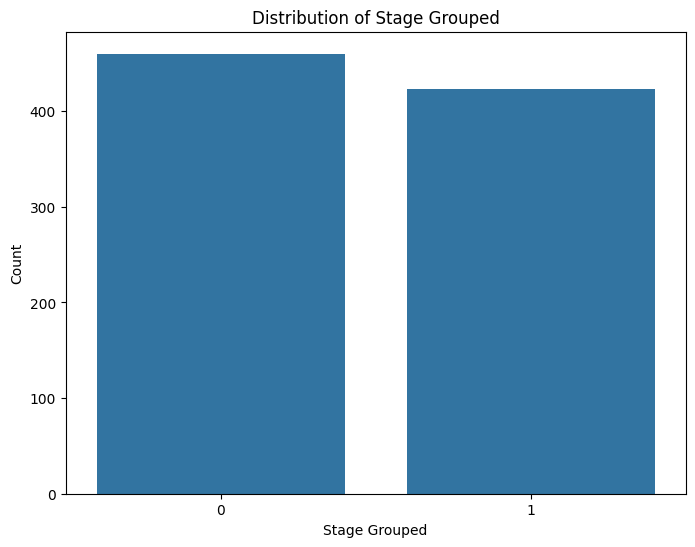

In [13]:
# Plot the distribution of the 'stage_grouped' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='stage_grouped')
plt.title('Distribution of Stage Grouped')
plt.xlabel('Stage Grouped')
plt.ylabel('Count')
plt.show()

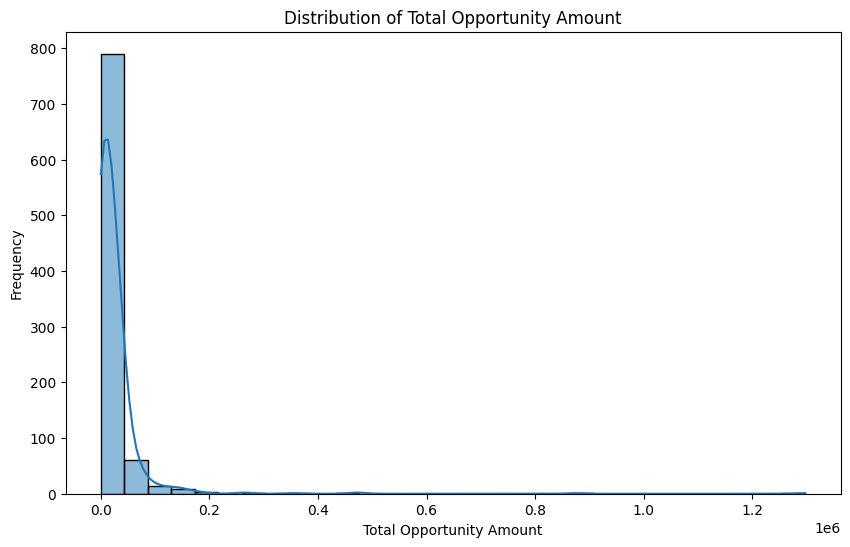

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data['total_opp_amount'], bins=30, kde=True)
plt.title('Distribution of Total Opportunity Amount')
plt.xlabel('Total Opportunity Amount')
plt.ylabel('Frequency')
plt.show()

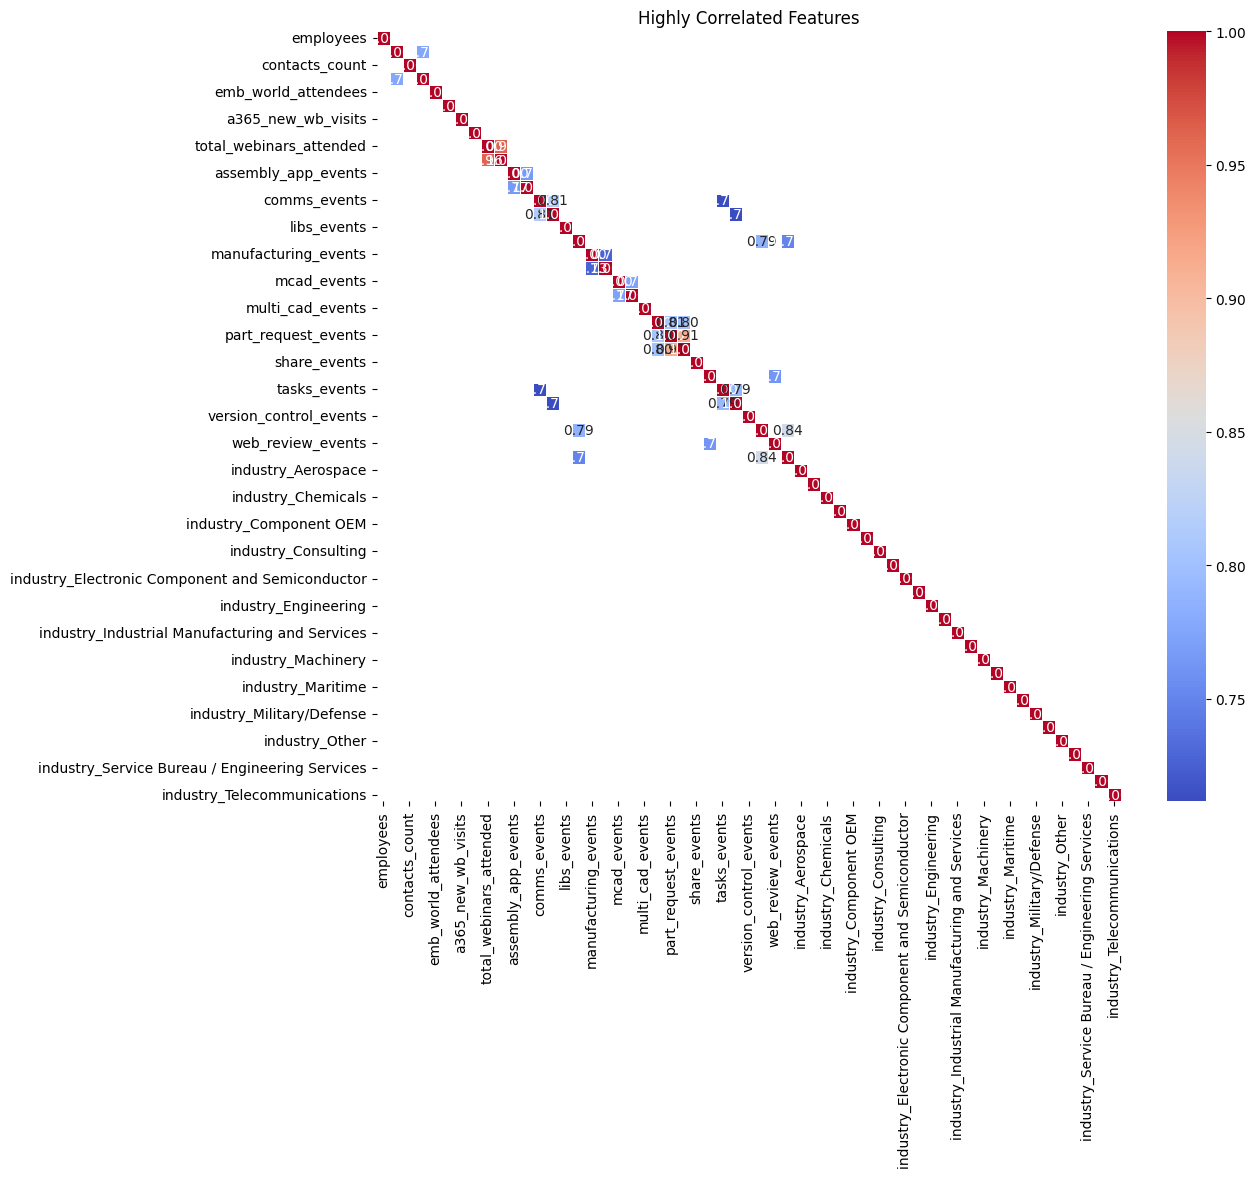

In [18]:
# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X, columns=features).corr()

# Filter the correlation matrix to show only highly correlated features
high_corr = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]

# Plot the heatmap for highly correlated features
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Highly Correlated Features")
plt.show()

In [19]:
# List out the highly correlated features and what they are correlated with
high_corr_features = []
for i in range(len(high_corr.columns)):
    for j in range(i):
        if abs(high_corr.iloc[i, j]) > 0.7:
            high_corr_features.append((high_corr.columns[i], high_corr.columns[j], high_corr.iloc[i, j]))

# Sort the list by the absolute value of the correlation in descending order
high_corr_features = sorted(high_corr_features, key=lambda x: abs(x[2]), reverse=True)
high_corr_features

[('total_webinar_attendees',
  'total_webinars_attended',
  np.float64(0.9618387156381312)),
 ('part_request_days_used',
  'part_request_events',
  np.float64(0.913071507757069)),
 ('web_review_days_used',
  'version_control_days_used',
  np.float64(0.8430530272699593)),
 ('comms_days_used', 'comms_events', np.float64(0.8144829419463909)),
 ('part_request_events',
  'multi_cad_days_used',
  np.float64(0.8052464982945013)),
 ('part_request_days_used',
  'multi_cad_days_used',
  np.float64(0.8027161690891124)),
 ('tasks_days_used', 'tasks_events', np.float64(0.7938076192629052)),
 ('version_control_days_used',
  'libs_days_used',
  np.float64(0.7852773453664932)),
 ('non_ee_count', 'ee_count', np.float64(0.7763765701475528)),
 ('mcad_days_used', 'mcad_events', np.float64(0.772932410630266)),
 ('assembly_app_days_used',
  'assembly_app_events',
  np.float64(0.7658879131705933)),
 ('web_review_events', 'share_days_used', np.float64(0.7633798331305922)),
 ('web_review_days_used', 'libs_days

## Build train/test splits

In [53]:
# Create list of features to drop
features_to_drop = ['share_days_used','web_review_days_used','manufacturing_days_used','tasks_days_used','non_ee_count','mcad_days_used','assembly_app_days_used','comms_events','total_webinar_attendees','part_request_days_used','version_control_days_used','multi_cad_days_used']
#features_to_drop = []
# Columns to drop

columns_to_drop = ['customer_number','stage_grouped','max_closed_date','cloud_revenue','total_opp_amount','country']

# Create feature sets
X = data.drop(columns=features_to_drop + columns_to_drop)
y_class = data['stage_grouped']

X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

In [54]:
# Correlation Analysis to see how features correlate with the target
print("Correlation Analysis:")
correlation_matrix = pd.DataFrame(X, columns=data.drop(columns=columns_to_drop + features_to_drop).columns).corrwith(pd.Series(y_class)).abs()
print(correlation_matrix.sort_values(ascending=False))

Correlation Analysis:
libs_days_used                                     0.227639
comms_days_used                                    0.131746
web_review_events                                  0.116191
version_control_events                             0.108136
a365_rest_wb_visits                                0.101293
mcad_events                                        0.093545
industry_Aerospace                                 0.089298
multi_cad_events                                   0.079669
tasks_events                                       0.078125
manufacturing_events                               0.077596
part_request_events                                0.077008
assembly_app_events                                0.070631
total_webinars_attended                            0.064571
industry_Component OEM                             0.051867
industry_Maritime                                  0.047121
industry_Engineering                               0.043841
industry_Service B

## Check feature importance

Feature Importance from Random Forest:


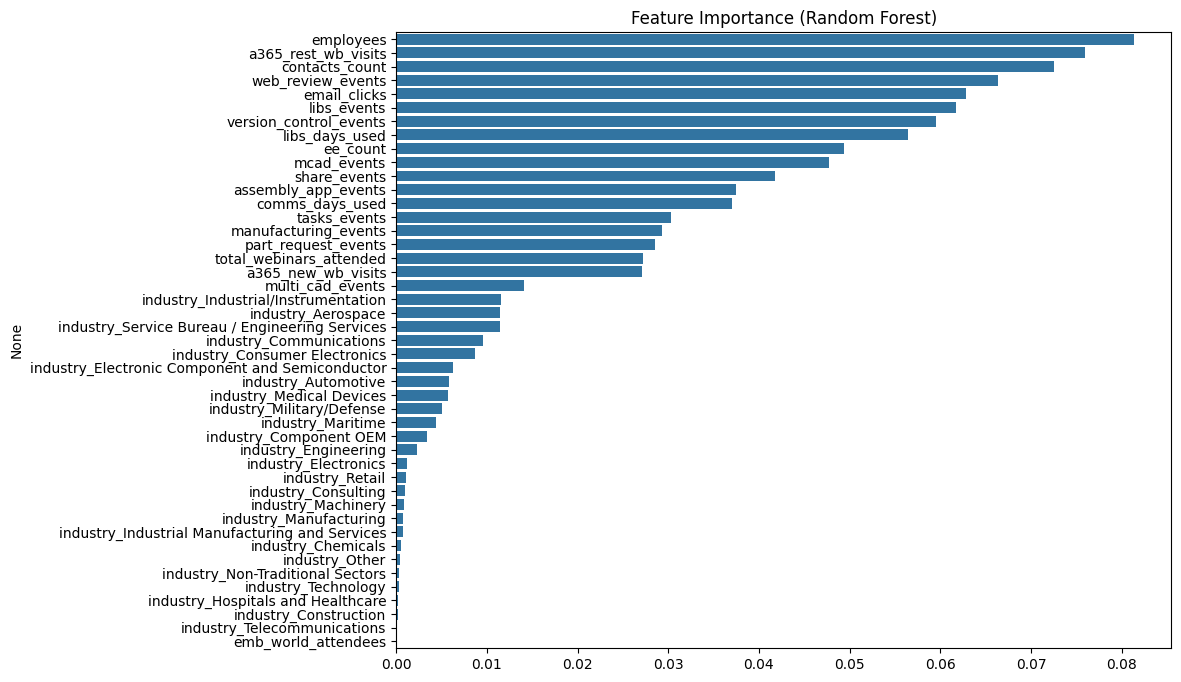

In [83]:
# Feature importance using a Random Forest classifier to see which features are most important
print("Feature Importance from Random Forest:")
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train_class)
importances = rf_classifier.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = data.drop(columns=features_to_drop + columns_to_drop).columns[indices]

# Plot feature importances as a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Feature Importance (Random Forest)")
plt.show()

Feature Importance from XGBoost:


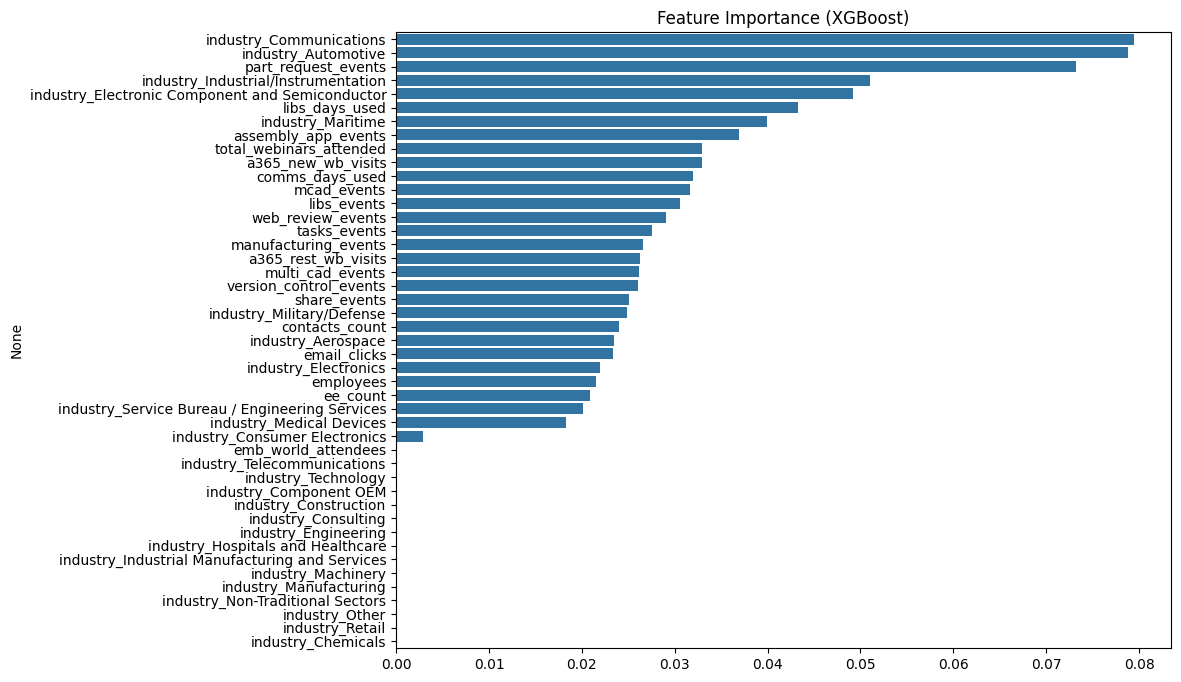

In [56]:
# Feature Importance using XGBoost
print("Feature Importance from XGBoost:")
xgb_classifier = XGBClassifier(eval_metric='logloss')
xgb_classifier.fit(X_train, y_train_class)
importances_xgb = xgb_classifier.feature_importances_

# Sort the feature importances in descending order
indices_xgb = np.argsort(importances_xgb)[::-1]
sorted_importances_xgb = importances_xgb[indices_xgb]
sorted_features_xgb = data.drop(columns=features_to_drop + columns_to_drop).columns[indices_xgb]

# Plot XGBoost feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances_xgb, y=sorted_features_xgb)
plt.title("Feature Importance (XGBoost)")
plt.show()

## Quick logistic test (baseline)

In [57]:
# Create and train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train_class)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_class, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.58      0.63        92
           1       0.61      0.73      0.67        85

    accuracy                           0.65       177
   macro avg       0.66      0.65      0.65       177
weighted avg       0.66      0.65      0.65       177



/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


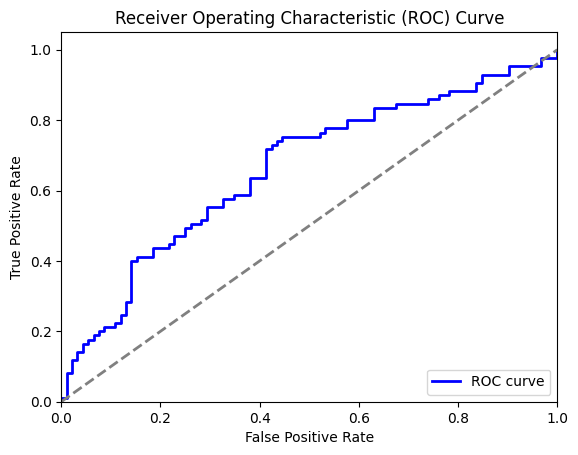

AUC: 0.6621483375959079


In [58]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_class, logistic_model.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')

In [59]:
# See coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]
coefficients = pd.Series(coefficients, index=X.columns)
coefficients = coefficients.sort_values(ascending=False)
coefficients

multi_cad_events                                   1.735793e-02
libs_days_used                                     7.226854e-03
a365_new_wb_visits                                 1.885013e-03
industry_Aerospace                                 9.732256e-04
manufacturing_events                               7.383614e-04
a365_rest_wb_visits                                3.956168e-04
industry_Electronic Component and Semiconductor    3.336390e-04
share_events                                       3.015500e-04
assembly_app_events                                2.836712e-04
industry_Maritime                                  2.350588e-04
industry_Consumer Electronics                      1.160689e-04
tasks_events                                       1.094583e-04
industry_Telecommunications                        6.856078e-05
emb_world_attendees                                6.500570e-05
mcad_events                                        3.969082e-05
industry_Hospitals and Healthcare       

### Check coefficient significance of baseline model

In [60]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Ensure X_train is numpy array
X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])]

# Fit original model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_array, y_train_class)
coef_orig = model.coef_[0]

# Set up bootstrap parameters
n_iterations = 1000
confidence_level = 0.95
n_features = X_train_array.shape[1]

# Initialize arrays for bootstrap results
coef_boots = np.zeros((n_iterations, n_features))

# Perform bootstrap
print("Performing bootstrap iterations...")
for i in range(n_iterations):
    # Create bootstrap sample
    X_boot, y_boot = resample(X_train_array, y_train_class)
    
    # Fit model and store coefficients
    model_boot = LogisticRegression(max_iter=1000)
    model_boot.fit(X_boot, y_boot)
    coef_boots[i,:] = model_boot.coef_[0]
    
    # Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Completed {i + 1} iterations")

# Calculate statistics
ci_lower = np.percentile(coef_boots, ((1 - confidence_level) / 2) * 100, axis=0)
ci_upper = np.percentile(coef_boots, (1 - (1 - confidence_level) / 2) * 100, axis=0)
std_errors = np.std(coef_boots, axis=0)
z_scores = coef_orig / std_errors
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

# Create results DataFrame
results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_orig,
    'Std_Error': std_errors,
    'Z_Score': z_scores,
    'P_Value': p_values,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper,
    'Significant': p_values < 0.05
})

# Sort by absolute z-score
results = results.sort_values(by='Z_Score', key=abs, ascending=False)

# Print results
print("\nCoefficient Significance Analysis:")
print("==================================")
print(f"\nNumber of significant features (p < 0.05): {results['Significant'].sum()}")
print("\nTop 10 most significant features:")
print(results.head(10).to_string())

# Print summary statistics
print("\nSummary Statistics:")
print("==================")
print(f"Total features: {len(results)}")
print(f"Significant features: {results['Significant'].sum()}")
print(f"Average absolute coefficient: {abs(results['Coefficient']).mean():.4f}")
print(f"Average p-value: {results['P_Value'].mean():.4f}")

# Print strongest effects
print("\nStrongest Positive Effects:")
print(results[results['Coefficient'] > 0].head(5)[['Feature', 'Coefficient', 'P_Value']].to_string())

print("\nStrongest Negative Effects:")
print(results[results['Coefficient'] < 0].head(5)[['Feature', 'Coefficient', 'P_Value']].to_string())

/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Performing bootstrap iterations...


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 100 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 200 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 300 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 400 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 500 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 600 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 700 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 800 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 900 iterations


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Completed 1000 iterations

Coefficient Significance Analysis:

Number of significant features (p < 0.05): 1

Top 10 most significant features:
                                           Feature  Coefficient  Std_Error   Z_Score   P_Value  CI_Lower  CI_Upper  Significant
11                                  libs_days_used     0.007227   0.002692  2.684409  0.007266  0.001891  0.012535         True
14                                multi_cad_events     0.017358   0.011503  1.508934  0.131316 -0.001017  0.045360        False
8                              assembly_app_events     0.000284   0.000282  1.005479  0.314666 -0.000235  0.000936        False
10                                     libs_events    -0.000027   0.000027 -0.994716  0.319874 -0.000097  0.000020        False
19                               web_review_events    -0.000013   0.000016 -0.854428  0.392868 -0.000043  0.000018        False
13                                     mcad_events     0.000040   0.000061  0.654967  0.5

/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_79172/737113310.py:44: RuntimeWarning: invalid value encountered in divide
  z_scores = coef_orig / std_errors


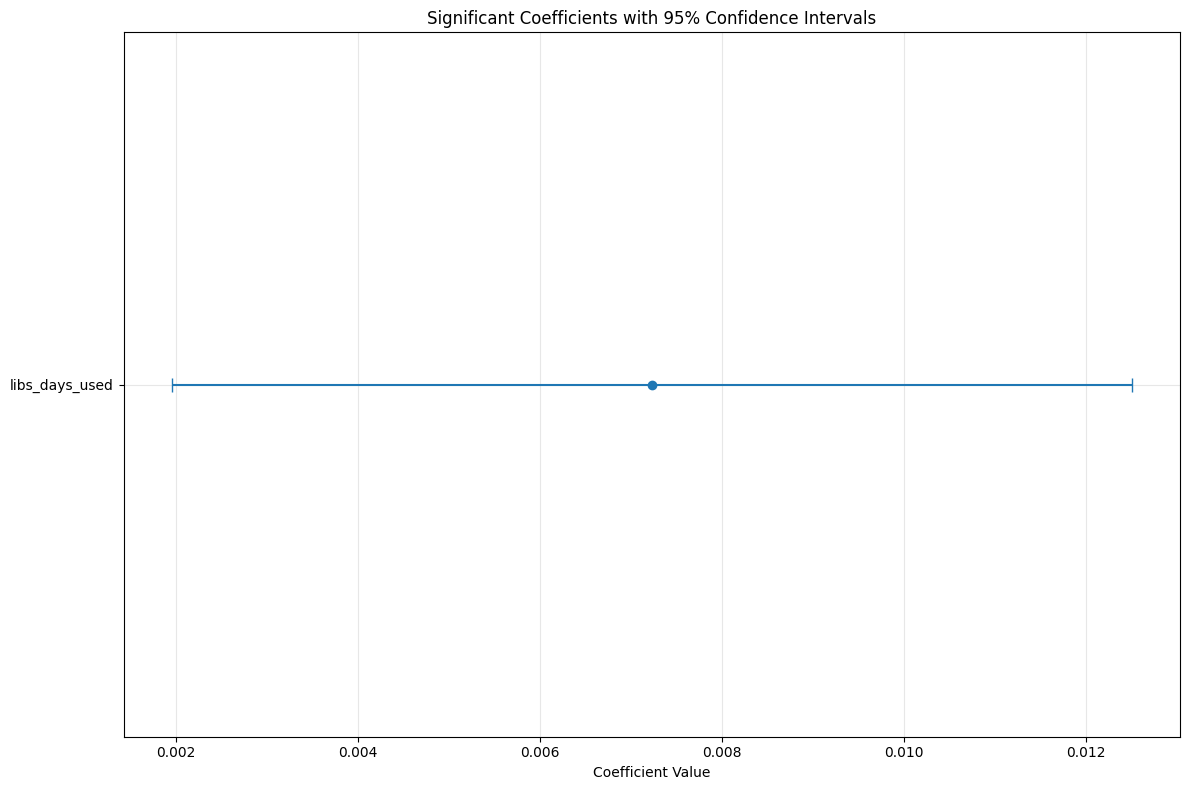

In [61]:
# Create visualization
plt.figure(figsize=(12, 8))
significant_features = results[results['Significant']]

plt.errorbar(
    significant_features['Coefficient'],
    range(len(significant_features)),
    xerr=1.96 * significant_features['Std_Error'],
    fmt='o',
    capsize=5
)

plt.yticks(range(len(significant_features)), significant_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Significant Coefficients with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## PCA Analysis

In [62]:
# PCA (Principal Component Analysis) to reduce dimensionality while retaining 95% of the variance
print("Principal Component Analysis (PCA):")
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)}")

Principal Component Analysis (PCA):
Number of components selected: 4
Explained variance ratio: [0.51307045 0.30317939 0.10015501 0.07640707]
Total explained variance: 0.9928119182266099


In [63]:
# Get the components (loadings) of the PCA
components = pca.components_

# Create a DataFrame to see the contribution of each feature to each principal component
pca_df = pd.DataFrame(components, columns=X.columns.tolist())
print("\nContribution of each feature to the principal components:")
print(pca_df)


Contribution of each feature to the principal components:
   employees  ee_count  contacts_count  emb_world_attendees  email_clicks  \
0   0.995471 -0.000001       -0.000028        -2.443688e-08     -0.000170   
1   0.095003  0.000185        0.002155         1.387540e-07      0.001569   
2   0.002416  0.000097        0.001684         1.313677e-07      0.000384   
3   0.001914  0.000151        0.001538         2.505891e-07      0.001735   

   a365_new_wb_visits  a365_rest_wb_visits  total_webinars_attended  \
0           -0.000023            -0.000338                -0.000007   
1            0.000330             0.004195                 0.000041   
2            0.000195            -0.000126                 0.000006   
3            0.000100            -0.000103                 0.000007   

   assembly_app_events  comms_days_used  ...  industry_Manufacturing  \
0            -0.001274        -0.000206  ...            2.816728e-08   
1             0.008062         0.001537  ...           

In [64]:
# Run logistic regression with pca features
logistic_model_pca = LogisticRegression()
logistic_model_pca.fit(X_train_pca, y_train_class)

# Make predictions
y_pred_pca = logistic_model_pca.predict(X_test_pca)

# Evaluate the model
print(classification_report(y_test_class, y_pred_pca))

# Calculate the AUC
roc_auc_pca = roc_auc_score(y_test_class, logistic_model_pca.predict_proba(X_test_pca)[:, 1])
print(f'AUC: {roc_auc_pca}')

              precision    recall  f1-score   support

           0       0.55      0.91      0.69        92
           1       0.68      0.20      0.31        85

    accuracy                           0.57       177
   macro avg       0.62      0.56      0.50       177
weighted avg       0.61      0.57      0.51       177

AUC: 0.6448849104859335


## Create metrics table

In [65]:
# Dictionary to store the metrics for each model
metrics_table = {
    'Model': [],
    'Best Parameters': [],
    'Accuracy': [],
    'AUC': []
}

## Perform classification modeling

In [66]:
# Classification Models with Hyperparameter Tuning
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['none', 'l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'class_weight': ['balanced', None]
    },
    'SVM': {
        'C': [0.1, 1, 10]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5]
    }
}

for name, model in tqdm(classifiers.items(), desc="Model Training"):
    print("Training model:", name)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], scoring='accuracy', cv=5, n_jobs=-1)
    #grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid[name], n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
    grid_search.fit(X_train, y_train_class)
    best_model = grid_search.best_estimator_
    y_pred_class = best_model.predict(X_test)
    y_prob_class = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_class, y_pred_class)
    if hasattr(best_model, "predict_proba"):
        y_prob_class = best_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test_class, y_prob_class)
    else:
        y_prob_class = None
        auc = None
    
    # Store metrics in the table
    metrics_table['Model'].append(name)
    metrics_table['Best Parameters'].append(grid_search.best_params_)
    metrics_table['Accuracy'].append(accuracy)
    metrics_table['AUC'].append(auc)

Model Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: Logistic Regression


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Training model: Random Forest


Model Training:  40%|████      | 2/5 [00:03<00:05,  1.80s/it]

Training model: SVM


Model Training:  60%|██████    | 3/5 [00:03<00:02,  1.09s/it]

Training model: K-Nearest Neighbors
Training model: XGBoost


Model Training: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


### Neural Network

In [67]:
# model code here
K.clear_session()
text_input = Input(shape=(X_train.shape[1],))
hidden_state = Dense(
    32,
    activation="relu",
    kernel_regularizer=l2(1e-4),
)(text_input)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(
    16,
    activation="relu",
)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(1, activation="sigmoid")(hidden_state)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,017 (7.88 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Ensure the input data is in the correct format
X_train_class = np.array(X_train).astype(np.float32)
y_train_class = np.array(y_train_class).astype(np.float32)
X_test_class = np.array(X_test).astype(np.float32)
y_test_class = np.array(y_test_class).astype(np.float32)

# fit the model
lr = ReduceLROnPlateau(patience=1, verbose=True)
es = EarlyStopping(patience=2, verbose=True)

model.fit(
    X_train_class,
    y_train_class,
    epochs=300,
    batch_size=512,
    validation_data=(X_test_class, y_test_class),
    callbacks=[lr, es]
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.4723 - loss: 312.8853 - val_acc: 0.3785 - val_loss: 118.2265 - learning_rate: 0.0010
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5033 - loss: 258.9848 - val_acc: 0.3898 - val_loss: 96.4831 - learning_rate: 0.0010
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4835 - loss: 316.2136 - val_acc: 0.4011 - val_loss: 78.2621 - learning_rate: 0.0010
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4835 - loss: 287.7518 - val_acc: 0.4350 - val_loss: 66.1113 - learning_rate: 0.0010
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5042 - loss: 218.8181 - val_acc: 0.4520 - val_loss: 61.1613 - learning_rate: 0.0010
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5015 - loss: 293.3080 - val_acc: 0.4576 - val_loss: 59.5532 - learning_rate: 0.0010
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - acc: 0.4958 - loss: 284.4337
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001

In [69]:
# Ensure the input data is in the correct format
X_test_class = np.array(X_test).astype(np.float32)
y_test_class = np.array(y_test_class).astype(np.float32)

# Evaluate the deep learning classification model
loss, accuracy = model.evaluate(X_test_class, y_test_class)
y_prob_class_dl = model.predict(X_test_class).flatten()
auc = roc_auc_score(y_test_class, y_prob_class_dl)

# Store deep learning classification metrics in the table
metrics_table['Model'].append("Deep Learning (Classification)")
metrics_table['Best Parameters'].append(None)
metrics_table['Accuracy'].append(accuracy)
metrics_table['AUC'].append(auc)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - acc: 0.4144 - loss: 76.4364
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### See metrics for all models

In [70]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table).sort_values(by='AUC', ascending=False)
metrics_table_sorted

,Model,Best Parameters,Accuracy,AUC
2,SVM,{'C': 10},0.610169,0.714962
4,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'min_c...",0.632768,0.683248
1,Random Forest,"{'class_weight': None, 'max_depth': 20, 'n_est...",0.632768,0.678836
0,Logistic Regression,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.587571,0.624041
3,K-Nearest Neighbors,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.576271,0.599488
5,Deep Learning (Classification),None,0.446328,0.535806


### Plot best results

AUC for SVM (C=10): 0.714769820971867


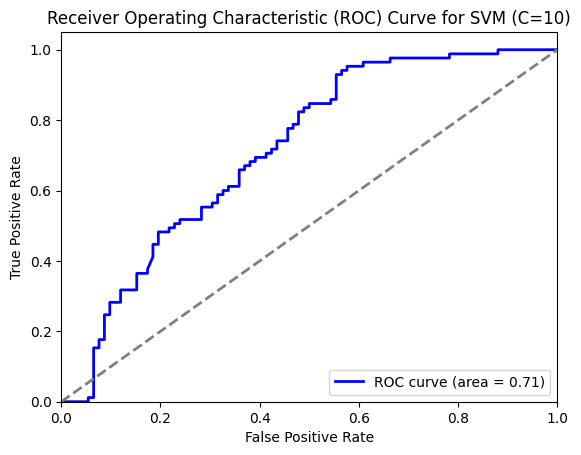

In [71]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Fit the SVM model with C = 10
svm_model = SVC(C=10, probability=True)
svm_model.fit(X_train, y_train_class)

# Predict probabilities
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_class, y_prob_svm)

# Calculate the AUC
auc_svm = roc_auc_score(y_test_class, y_prob_svm)
print(f'AUC for SVM (C=10): {auc_svm}')

# Plot the ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_svm, tpr_svm))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM (C=10)')
plt.legend(loc="lower right")
plt.show()

In [72]:
# Calculate the AUC for the SVM model
auc_svm = roc_auc_score(y_test_class, y_prob_svm)
print(f'AUC for SVM: {auc_svm}')

AUC for SVM: 0.714769820971867


### Export best model

In [73]:
# Save the random forest model as a pickle file
import pickle

with open('app/models/svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

## Perform regression modeling

In [74]:
y_reg = data['total_opp_amount']
y_reg

0       10497.00
1         999.00
2       72231.75
3      154342.39
4       15000.00
         ...    
878      6280.99
879      6694.59
880      3009.59
881      1055.99
882      7994.00
Name: total_opp_amount, Length: 883, dtype: float64

In [75]:
print(X.shape, y_reg.shape)

(883, 45) (883,)


In [76]:
# Create a single train-test split to use consistently
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

In [77]:
# Dictionary to store the metrics for each model
metrics_table_reg = {
    'Model': [],
    'Best Parameters': [],
    'MSE': [],
    'R2 Score': []
}

In [78]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Regression Models with Hyperparameter Tuning
regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

param_grid_reg = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

logger.info("\nRegression Results with Hyperparameter Tuning:")
for name, model in regressors.items():
    logger.info(f"Training {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_reg[name], scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train_reg)
    best_model = grid_search.best_estimator_
    y_pred_reg = best_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    accuracy = None  # Not applicable for regression
    auc = None       # Not applicable for regression
    
    # Store metrics in the table
    metrics_table_reg['Model'].append(name)
    metrics_table_reg['Best Parameters'].append(grid_search.best_params_)
    metrics_table_reg['MSE'].append(mse)
    metrics_table_reg['R2 Score'].append(r2)
    
    logger.info(f"Completed {name}. Best Parameters: {grid_search.best_params_}, MSE: {mse}, R2: {r2}")

INFO:__main__:
Regression Results with Hyperparameter Tuning:
INFO:__main__:Training Linear Regression...
INFO:__main__:Completed Linear Regression. Best Parameters: {}, MSE: 4506407496.191163, R2: -3.054573920534633
INFO:__main__:Training Random Forest...
INFO:__main__:Completed Random Forest. Best Parameters: {'max_depth': 30, 'n_estimators': 100}, MSE: 3023493882.827711, R2: -1.720344189150799
INFO:__main__:Training XGBoost...
INFO:__main__:Completed XGBoost. Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}, MSE: 1555910268.0440109, R2: -0.39990739870624537


### Neural network

In [79]:
K.clear_session()

# Ensure the input data is in the correct format
X_train_reg = np.array(X_train).astype(np.float32)
y_train_reg = np.array(y_train_reg).astype(np.float32)
X_test_reg = np.array(X_test).astype(np.float32)
y_test_reg = np.array(y_test_reg).astype(np.float32)

# model code here
K.clear_session()
text_input = Input(shape=(X_train_reg.shape[1],))
hidden_state = Dense(
    32,
    activation="relu",
    kernel_regularizer=l2(1e-4),
)(text_input)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(
    16,
    activation="relu",
)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(1)(hidden_state)
model = Model(text_input, output)
model.compile("adam", loss="mean_squared_error")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,017 (7.88 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# fit the model
lr = ReduceLROnPlateau(patience=1, verbose=True)
es = EarlyStopping(patience=2, verbose=True)

model.fit(
    X_train_reg,
    y_train_reg,
    epochs=300,
    batch_size=512,
    validation_data=(X_test_reg, y_test_reg),
    callbacks=[lr, es]
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5673456640.0000 - val_loss: 1574225792.0000 - learning_rate: 0.0010
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5872226816.0000 - val_loss: 1562242688.0000 - learning_rate: 0.0010
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5306012672.0000 - val_loss: 1550326528.0000 - learning_rate: 0.0010
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5785736704.0000 - val_loss: 1538725376.0000 - learning_rate: 0.0010
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5325500416.0000 - val_loss: 1527441792.0000 - learning_rate: 0.0010
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5118523904.0000 - val_loss: 1516694528.0000 - learning_rate: 0.0010
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5888810496.0000 - val_loss: 1506086912.0000 - learning_rate: 0.0010
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5343900160.0000 - val_loss: 1495603200.0000 - learning_rate: 0.

In [81]:
# Evaluate the model on the test data
y_pred_reg_dl = model.predict(X_test_reg).flatten()  # Make predictions and flatten the output
mse = mean_squared_error(y_test_reg, y_pred_reg_dl)  # Calculate mean squared error
r2 = r2_score(y_test_reg, y_pred_reg_dl)  # Calculate R2 score
accuracy = None  # Not applicable for regression
auc = None       # Not applicable for regression

# Store deep learning regression metrics in the table
metrics_table_reg['Model'].append("Deep Learning (Regression)")
metrics_table_reg['Best Parameters'].append(None)  # No hyperparameters to report
metrics_table_reg['MSE'].append(mse)
metrics_table_reg['R2 Score'].append(r2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### See regression model results

In [ ]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table_reg).sort_values(by='R2 Score', ascending=False)
metrics_table_sorted

,Model,Best Parameters,MSE,R2 Score
3,Deep Learning (Regression),None,1.274836e+09,-0.147015
2,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.555910e+09,-0.399907
1,Random Forest,"{'max_depth': 30, 'n_estimators': 100}",3.023494e+09,-1.720344
0,Linear Regression,{},4.506407e+09,-3.054574
